### 1. Data Import and Base Variable 확인

 * id : 식별자 for each trip
 * vendor_id : 공급자 코드(a code indicating the provider associated with the trip record)
 * pickup_datetime : 탑승 날짜 및 시각(date and time when the meter was engaged)
 * dropoff_datetime : 하차 날짜 및 시각(date and time when the meter was disengaged)
 * passengers in the vehicle : 승객수(driver entered value)
 * pickup_longitude : 탑승 경도(the longitude where the meter was engaged)
 * pickup_latitude : 탑승 위도(the latitude where the meter was engaged)
 * dropoff_longitude : 하차 경도(the longitude where the meter was disengaged)
 * dropoff_latitude : 하차 위도(the latitude where the meter was disengaged)
 * store_and_fwd_flag : 차량메모리 보관여부(this flage indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server. Y = store and forward, N = not a store and forward trip)
 * trip_duration : duration of the trip in seconds

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#### 1) csv 데이터로 부터 DataFrame 생성
- 데이터 분석을 위해, dataframe을 생성하는 가장 일반적인 방법
- 데이터 소스로부터 추출된 csv(comma separated values) 파일로부터 생성
* *tip : github는 push 할 수 있는 파일 1개 최대 용량이 100mb이므로 csv파일을 push할 경우 error발생  
github에 csv은 push 못하므로, csv 파일은 add 하지말고 ipynb(주피터노트북파일 확장자) 파일만 add *

In [2]:
# notebook파일 생성한 폴더에 csv파일을 옮겨두고 data import 및 dataframe 생성
taxi_df = pd.read_csv('train.csv')

#### 2) DataFrame 살펴보기
 - shape           : row, column 개수 확인
 - head(), tail()  : 데이터 확인
 - describe()      : 각 column별 간략한 통계정보 
 - info()          : 각 column별 타입 정보

In [3]:
taxi_df.shape

(701778, 11)

In [ ]:
# data에 이상치가 있는지 확인하기 위해 초기 값과 마지막 값 확인
taxi_df

In [ ]:
taxi_df.describe()

In [4]:
# Variable Type 확인
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701778 entries, 0 to 701777
Data columns (total 11 columns):
id                    701778 non-null object
vendor_id             701778 non-null int64
pickup_datetime       701778 non-null object
dropoff_datetime      701778 non-null object
passenger_count       701778 non-null int64
pickup_longitude      701778 non-null float64
pickup_latitude       701778 non-null float64
dropoff_longitude     701778 non-null float64
dropoff_latitude      701778 non-null float64
store_and_fwd_flag    701778 non-null object
trip_duration         701778 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 58.9+ MB


### 2. Data Pre-Processing
#### 1) Datatime Type Vriable Modify 

* **Datetime Type Conversion**
    * pickup_datetime, dropoff_datetime은 type이 datetime이어야 시간변수로 활용할 수  
    있으나, object(=string)임
    * 시간변수로 활용하기 위해 type을 datetime으로 바꿔줘야 함
    * pandas의 to_datetime을 활용해 type을 datetime으로 바꿔줄 수 있음
    * datafrme의 변수타입을 변경하는 코드는 다음과 같음
        * 방법 1  
        taxi_df.pickup_datetime = pd.to_datetime(taxi_df.pickup_datetime)  
        * 방법 2  
        taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime']) 
    * dataframe에서 새로운 변수를 생성할 경우 등호(=)의 오른쪽은 df.변수명, df['변수명']  
    둘다 상관 없으나, 새로운 변수명(왼쪽)은 df['변수명']으로 적어야 생성됨  
    새로운 변수명(왼쪽)을 df.변수명으로 적을 경우 kernel이 작동하지만 실제로 생성은 안됨

In [ ]:
# 시간변수 type 확인 skip
taxi_df.pickup_datetime.dtype

In [5]:
# 시간변수 type을 datetime으로 변환(pandas datetimeIndex 이용)
# 혹시 너무 오래 걸리면 여기서 sampling을 함
taxi_df = taxi_df.sample(frac = 0.1, replace = False, random_state = 0) #sampling
taxi_df.pickup_datetime = pd.to_datetime(taxi_df.pickup_datetime)
taxi_df.dropoff_datetime = pd.to_datetime(taxi_df.dropoff_datetime)

In [ ]:
# 참고 skip
# pickup - dropoff의 계산을 통해 trip_duration 검증 및 pickup, dropoff, trip_duration 변수 관계 확인
taxi_df.trip_duration_c = taxi_df.dropoff_datetime - taxi_df.pickup_datetime

# trip_duration_c는 day 단위로 산출됨. 그러나 trip_duration의 단위는 second임 따라서 day를 second단위로 변환
taxi_df.trip_duration_c = taxi_df.trip_duration_c.dt.total_seconds()

##### (1) Slicing Method     (skip)
* **Datetime Package를 쓰면 빠르고 쉽게 할 수 있음. (2)로 이동
* **pickup_datetime의 년, 월, 일을 각각 새로운 변수로 생성함**
    * trip_duration과 pickup한 년, 월, 일 별로 상관관계가 있을 것 같아서 새로운 변수를 생성하고자 함
        * ex) 아주 춥거나 더운 달(12, 1, 2, 7, 8월에 택시를 탈 경우 trip_duration이 다른 월보다 길 수 있다고 생각함)
        * 뉴욕의 날씨를 확인해서 춥거나 더운 달과 그렇지 않은 달로 구분해서 더미변수를 만들 경우 설명변수로 사용 가능 할 것으로 판단
    * trip_duration이 pickup_datetime과 dropoff_datetime의 차로 형성된 변수임
        * 따라서  trip_duration를 이용해 새로운 변수를 만들고 그 변수를 설명변수로 사용할 경우 다중공선성이 발생할 가능성이 있음
        * 하지만 pickup_datetime이 시간변수이기 때문에 이에 대해 확신할 수 없어서 일단 해보기로 함
        * 그래서 부득이 slicing을 사용함 

In [ ]:
# pickup_datetime을 각 항목별로 slicing (slicing은 str밖에 안되므로 타입을 str로바꿔서 slicing)
taxi_df['pickup_datetime'] = taxi_df.pickup_datetime.astype(str)
taxi_df['pickup_year'] = taxi_df.pickup_datetime.str[:4]

# pickup_year의 type을 string에서 int로 다시 바꿔줌
taxi_df['pickup_year'] = taxi_df.pickup_year.astype(int)

# 위의 방법을 month, day, hour, mm에 반복  (보다 효율적으로 하는 방법(loop등)이 있을 것 같음)
taxi_df['pickup_month'] = taxi_df.pickup_datetime.str[5:7]
taxi_df['pickup_month'] = taxi_df.pickup_month.astype(int)
taxi_df['pickup_day'] = taxi_df.pickup_datetime.str[8:10]
taxi_df['pickup_day'] = taxi_df.pickup_day.astype(int)
taxi_df['pickup_hour'] = taxi_df.pickup_datetime.str[10:13]
taxi_df['pickup_hour'] = taxi_df.pickup_hour.astype(int)
taxi_df['pickup_mm'] = taxi_df.pickup_datetime.str[14:16]
taxi_df['pickup_mm'] = taxi_df.pickup_mm.astype(int)

# 생성된 변수 타입 확인
taxi_df.info()

# 생성된 변수 dataframe 적용 확인
taxi_df.head()

##### (2) Use the Pandas.Datetimeindex module
* dataframe_name.datetime_variable_name.dt.**option**  
**option**(year, month, day, hour, dayofyear, dayofweek 등)은 [참고링크](https://pandas.pydata.org/pandas-docs/stable/api.html#datetimeindex)에서 확인
---
* 특정 변수 생성(datetime variable에서 연, 월, 일 각각 변수로 분리)  
일 변수 : taxi_df['pickup_day'] = taxi_df.pickup_datetime.dt.day  
* 단위 변환한 변수 생성(week 기준 몇번째 일이냐, 요일 변수 생성)  
요일변수 : taxi_df['wday'] = taxi_df.pickup_datetime.dt.weekday

In [6]:
# 탄 시간, 일, 월, 연도 변수 생성
taxi_df['pickup_hour'] = taxi_df.pickup_datetime.dt.hour
taxi_df['pickup_day'] = taxi_df.pickup_datetime.dt.day
taxi_df['pickup_month'] = taxi_df.pickup_datetime.dt.month
taxi_df['pickup_year'] = taxi_df.pickup_datetime.dt.year

In [7]:
# 연도, 주 기준 변수 생성
taxi_df['yday'] = taxi_df.pickup_datetime.dt.dayofyear
taxi_df['wday'] = taxi_df.pickup_datetime.dt.dayofweek
taxi_df['nwday'] = taxi_df.pickup_datetime.dt.weekday_name

#### tip : 기존 dataframe에 변수를 추가했을 때 활용할 수 있는 명령어(변수명 변경, 변수 삭제, 변수 순서 변경)
* 변수명(column) 변경(rename)
    * 방법1 : dataframe_name = dataframe_name.rename(columns = {'oldname1' : 'newname1', 'oldname2' : 'newname2'})
    * 방법2 : dataframe_name.rename(columns = {'oldname1' : 'newname1', 'oldname2' : 'newname2'}, inplace = True)
* 잘못 생성한 변수(column) 삭제(drop)
    * 방법1 : dataframe_name = dataframe_name.drop('column_name', axis = 1)  
    *axis = 1은 dataframe의 column을 의미(0은 row)*
    * 방법2 : dataframe_name.drop('column_name', axis = 1, inplace = True)
* 변수(column) 순서 변경(order or insert)
    * 방법1 : dataframe_name = dataframe_name.[['column1', 'column2']]
    * 방법2 : 특정자리에 특정 변수 삽입
        * get a list of columns   
        cols = list(df)
        * move the column to head of list using index, pop and insert  
        cols.insert(0, cols.pop(cols.index('Mid')))
        * use loc to reorder(라벨을 활용할 경우 loc, 위치 index를 활용할 경우 iloc)  
        df = df.loc[:, cols]                  

In [8]:
# 보통 종속변수를 table 가장 왼쪽에 둠
# panel data의 경우 기준변수를 가장 왼쪽에 둠. (ex id)
cols = list(taxi_df)
cols.insert(0, cols.pop(cols.index('trip_duration')))
taxi_df = taxi_df.loc[:, cols]

In [ ]:
taxi_df

In [ ]:
# pickup_month data 확인을 위해 grouping
month_group = taxi_df.groupby('pickup_month')

In [ ]:
# pickup_month의 value*column별 관측치 수 확인
month_group.count()

In [ ]:
# size함수를 통해 pickup_month의 value별 관측치 수 확인(count와 size의 차이 : size는 NaN값을 포함해서 세고, count는 NaN값을 세지 않음)
month_group.size().sort_values(ascending = False)

In [ ]:
# 그래프 그릴 때는 data가 너무 커서 sampling함
# sampleing(rawdata 10%, observation 약 7만개)
taxi_df = taxi_df.sample(frac = 0.1, replace = False, random_state = 0)

In [ ]:
# sample이 골고루 뽑혔는지 확인
# month_group.count()의 output과 비교. 월별 갯수 비중 확인

# pickup_month data 확인을 위해 grouping
month_group = taxi_df.groupby('pickup_month')
# pickup_month의 value*column별 관측치 수 확인
month_group.count()

##### (3) data log 변환
* trip_duration의 단위는 second로 log변환 가능
* trip_duration에 +1을 한 후 log 변환 수행  
*original 값에 +1을 하는 이유 :
original 값이 0인 경우 log변환하면 1이 되어버림 따라서, 모든 original 값에 1을 더함*
* tirp_duraiont+1을 log변환 함
* original 값과 log변환 값 비교

In [9]:
taxi_df['logtrip_duration'] = np.log(taxi_df.trip_duration + 1)

##### (4) Base Data Graph
* RawData가 너무 많을 경우 Sampling
* Graph 그리는 Package Import
    1. Matplotlib  
        * 간단한 시각화를 하는 경우 pylab subpackage만으로 충분함  
    import matplotlib as mpl  
    import matplotlib.pylab as plt  
    1. Seaborn  
        * Matplotlib을 기반으로 기능을 추가한 시각화 패키지로 Matplotlib에 의존  
    *Seaborn을 import하면 Matplotlib에서 제공하는 기본 스타일이 아닌 Seaborn에서 지정한 Default 스타일 집합으로 변경함  
    따라서 동일한 Matplotlib명령을 수행해도 Seaborn을 import한 것과 하지 않은 플롯은 모양이 다름*  
    import seaborn as sns  
    sns.set()  
    sns.set_color_codes()

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_color_codes()

In [ ]:
# trip_duration과 logtrip_duration의 kernel density graph
# 아래의 sns는 너무 오래걸림
'''
sns.distplot(taxi_df.trip_duration, kde = True, rug = True)
plt.show()
sns.distplot(taxi_df.logtrip_duration, kde = True, rug = True)
plt.show()
''''''

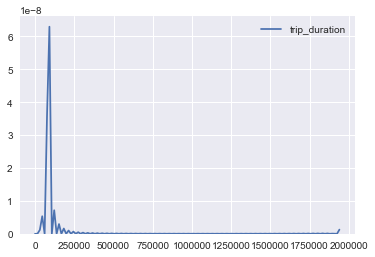

In [11]:
sns.kdeplot(taxi_df.trip_duration)
plt.show()
plt.xlabel("trip_duration")
plt.ylabel("trip_duration")

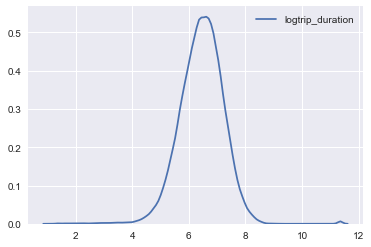

In [17]:
# 정규분포와 더 유사한 분포가 됨
sns.kdeplot(taxi_df.logtrip_duration)
plt.show()

* outlier라 판단되는 rawdata 확인
* outlier 삭제(1750000초 이상인 경우 빈도가 매우 적고 숫자가 너무 커 outlier로 판단) 
* *trip_duration이 20,000초 이상(5시간 이상)인 경우는 일반적인 상황이 아닌 것(분석 data에서 제외)으로 고려하고 분석할 수 있을 것으로 판단*

In [ ]:
plt.scatter(taxi_df.wday, taxi_df.trip_duration)
plt.xlabel("day of week")
plt.ylabel("trip_duration")
plt.show()

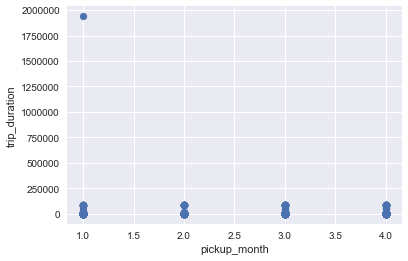

In [13]:
plt.scatter(taxi_df.pickup_month, taxi_df.trip_duration)
plt.xlabel("pickup_month")
plt.ylabel("trip_duration")
plt.show()

In [14]:
# 이상치라 판단되는 data확인
taxi_df[taxi_df.trip_duration >= 1750000]

# 아래의 형식으로도 확인 가능
# taxi_df[(taxi_df.trip_duration >= 1750000) & (taxi_df.trip_duration <= 2000000)]

,trip_duration,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_day,pickup_month,pickup_year,yday,wday,nwday,logtrip_duration
682482,1939736,id1864733,1,2016-01-05 00:19:00,2016-01-27 11:08:00,1,-73.78965,40.643559,-73.95681,40.773087,N,0,5,1,2016,5,1,Tuesday,14.478063


In [15]:
# 특정 관측치 삭제
#taxi_df = taxi_df.drop([682482])
#taxi_df = taxi_df.drop()(axis=0)

# 특정 범위만 grab
taxi_df = taxi_df[taxi_df.trip_duration <= 1750000]
#taxi_df[(taxi_df.trip_duration >= 1750000) & (taxi_df.trip_duration <= 2000000)]

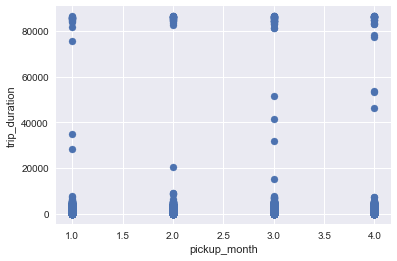

In [16]:
# 삭제되었는지 확인
plt.scatter(taxi_df.pickup_month, taxi_df.trip_duration)
plt.xlabel("pickup_month")
plt.ylabel("trip_duration")
plt.show()

In [19]:
from sklearn.datasets import make_regression
import statsmodels.formula.api as sm

In [20]:
result = sm.ols(formula = "logtrip_duration ~ pickup_month", data = taxi_df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       logtrip_duration   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     100.8
Date:                Thu, 12 Oct 2017   Prob (F-statistic):           1.08e-23
Time:                        17:53:41   Log-Likelihood:                -82460.
No. Observations:               70177   AIC:                         1.649e+05
Df Residuals:                   70175   BIC:                         1.649e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.3781      0.007    863.277   

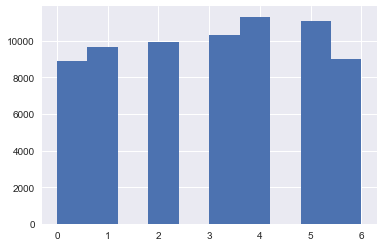

In [23]:
# pickup_month data histogram
plt.hist(taxi_df.wday)
plt.show()

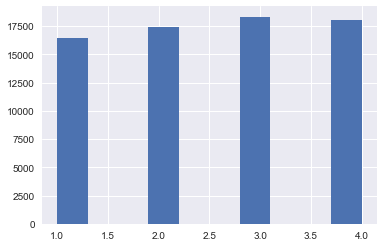

In [22]:
plt.hist(taxi_df.pickup_month)
plt.show()

In [ ]:
plt.hist(x, bins=None, range=None, normed=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, hold=None, data=None, **kwargs)

In [ ]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize = (10, 2))
plt.stem(hat)
plt.show()

In [ ]:
plt.figure(figersize=(10, 2))
plt.stem(result.)

In [ ]:
sns.rugplot(taxi_df.trip_duration)
plt.show()

In [ ]:
sns.kdeplot(taxi_df.trip_duration)
plt.show()

In [ ]:
sns.distplot(taxi_df.trip_duration, kde = True)
plt.show()

In [ ]:
newdf = taxi_df.copy()

In [ ]:
newdf = taxi_df.copy()
trip_duration = newdf.groupby('trip_duration')
newdf[np.abs(newdf.trip_duration - newdf.trip_duration.mean()) <= (3 * newdf.trip_duration.std())]
newdf['outlier'] = trip_duration.transform(lambda x: abs(x - x.mean()) > 1.96 * x.std())

In [ ]:
newdf

In [ ]:
plt.scatter(taxi_df.vendor_id, taxi_df.trip_duration)

In [ ]:
# vendor_id와 trip_duration간 scatter graph 
plt.scatter(len(taxi_df.vendor_id), taxi_df.trip_duration)

In [ ]:
plt.scatter(taxi_df.vendor_id, taxi_df.trip_duration)
plt.ylim(1930000, 1950000)

In [ ]:
plt.scatter(taxi_df.vendor_id, taxi_df.trip_duration)
plt.ylim(0, 150000)

In [ ]:
plt.scatter(taxi_df.pickup_latitude, taxi_df.pickup_longitude, s = taxi_df.trip_duration)

In [ ]:
mpl.rcParams['agg.path.chunksize'] = 10000

#### 3) Create Weather Variable
##### (1) Create Quarterly Category Variable
* pickup_month가 1월 ~ 4월까지 밖에 없음(kaggledata는 6월까지)
* 1, 2, 3월은 겨울의 계절성을 반영하고, 4, 5, 6월은 봄 ~ 초여름의 계절성을 반영한다고 가정함.
    * 사람들이 기후조건이 가혹할수록 더 택시를 오래 타고 있는다고 가정(날이 추우면 최대한 목적지에 가까운 장소까지 택시를 타고 간다.)
    * 이 가정을 반영하기 위해서는 뉴욕의 날씨를 확인해서 비오는 날과 맑은 날, 날짜별 온도를 변수화해서 반영하는 것이 보다 정확할 것으로 생각함 
        * 변수 2개 생성(날짜별로 비 or 눈이 왔다 0 나머지 1, 기온이 00도 이상 or 00도 이하 0, 나머지 1)해서 pickup_datetime으로 merge.
    * 가장 rough하게 변수를 생성해서 모형을 실행한 다음 이 변수가 유의미할 경우 더 세밀하게 변수를 조정하는 것이 나을 듯함
    
    
* 계절성을 반영한 분기별 카테고리 변수(pickup_month_c) 생성 1, 2, 3월은 0, 4, 5, 6월은 1의 값을 가짐.

In [ ]:
# pickup_month data 확인을 위해 grouping
month_group = taxi_df.groupby('pickup_month')

In [ ]:
# pickup_month의 value*column별 관측치 수 확인
month_group.count()

In [ ]:
# size함수를 통해 pickup_month의 value별 관측치 수 확인(count와 size의 차이 : size는 NaN값을 포함해서 세고, count는 NaN값을 세지 않음)
month_group.size().sort_values(ascending = False)

In [ ]:
# category variable 만듦(1, 2, 3월은 0, 4, 5, 6월은 1) (더미변수를 따로 만드는 것과 같은 효과라 판단함)
taxi_df['pickup_month_c'] = taxi_df.pickup_month.replace([1, 2, 3], '0')
taxi_df['pickup_month_c'] = taxi_df.pickup_month_c.replace([4], '1')

# type 변경(to category) 및 type 확인
taxi_df.pickup_month_c = taxi_df.pickup_month_c.astype('category')
taxi_df.dtypes

##### (2) Create wdf data
* 2016년 뉴욕 날씨 데이터를 입력하여 yday를 기준변수로 활용하여 기존 data frame에 merge함

In [ ]:
# 2016년 뉴욕 날씨 데이터 입력
wdf = pd.read_csv('weather_data_nyc_centralpark_2016.csv')

In [ ]:
wdf['date'] = pd.to_datetime(wdf.date,format='%d-%m-%Y')
wdf['yday'] = wdf.date.dt.dayofyear
# wdf['wday'] = wdf.date.dt.dayofweek
# wday변수는 wdf에서 안만들어도 될 것 같아서 만들지 않음
# merge하는데 필요한 기준 변수는 1개면 충분하다고 판단함

In [ ]:
# data확인결과 pricipitation 등의 변수에 숫자가 아닌 T가 있음
wdf.head(10)
# T는 측정되지 않았으나 비가왔던 흔적을 의미함
#"T" stands for "trace", used when precipitation has been detected, but it isn't sufficient to measure meaningfully.

In [ ]:
# T를 아주 작은 수로 바꿔줌(여기서는 0.01로 변경)
falls = [ 0.01 if c=='T' else float(c) for c in wdf['snow fall']]
rain = [ 0.01 if c=='T' else float(c) for c in wdf['precipitation']]
wdf['snow fall']= falls
wdf['precipitation'] = rain

In [ ]:
# 'yday' 변수를 기준변수로 taxi_df에 wdf를 merge함
# (yday를 기준으로 taxi_df에 wdf의 data를 가로로 붙인다.)
taxi_df = pd.merge(taxi_df,wdf,on='yday')
taxi_df

In [ ]:
# 필요없는 변수 삭제(maximum과 minimum은 같은 지역으로 다 같기 때문에 삭제)
taxi_df = taxi_df.drop(['date','maximum temperature','minimum temperature'], axis=1)
df.head()

* (temp) 독립변수(ex.pickup_month_c)와 종속변수(ex.trip_duration)의 상관관계 확인
* 상관계수 해석
    * +값은 비례, -값은 반비례를 의미
    * 상관계수의 크기에 따른 해석은 관행적으로 이뤄지는 것으로, 이론적 근거는 없음
        * 1.0 ~ 0.7 매우 강한 관련성
        * 0.7 ~ 0.4 상당한 관련성
        * 0.4 ~ 0.2 약간의 관련성
        * 0.2 ~ 0.0 관련성 없음

In [ ]:
# 설명변수 type이 int나 float와 같은 real변수일 경우
taxi_df[['trip_duration','pickup_month']].corr()

In [ ]:
# category변수일 경우(p-value를 소수점 2자리로 나오게 하는 방법 필요할 듯)
from scipy.stats import spearmanr, kendalltau, pearsonr
spearmanr(taxi_df['trip_duration'], taxi_df['pickup_month_c'])

##### 참고 : Pandas의 DatetimeIndex와 Python의 Datetime Package는 다름

> Python의 Datetime을 활용해 단위를 변경하는 명령어는 week와 관련된 명령어(weekday(), isoweekday()) 밖에 없음  
year와 month등을 기준(ex.1년 365일 중 4월 30일이 몇 번째 날)으로 datatime type 변수의 단위를 변경하기 위해서는 timetuple이나 strftime를 적용하여 사용하는 방법이 따로 적혀있음.   
그런데 dt.dayofyear, dayofweek, dayofmonth 등의 명령어가 실행이 됨.
[google 검색 결과](https://stackoverflow.com/questions/15707532/python-import-datetime-v-s-from-datetime-import-datetime)에서 import datetime as dt한 것을 보고 dt를 python의 datetime package로 오해함.  
그러나 참고한 자료에서는 import datetime 자체를 하지 않음.  
dt는 python의 datetime를 의미할 수도 있지만 여기서는 아닌 pandas의 **DatetimeIndex**를 의미함  

####### (2) Use the Datetime Package
* **Datatime Package를 이용해 연, 월, 일 변수 생성  **
    * datatime package 설치 : import datetime
    * df['option 기준 변수명'] = df['datetime_type_variable_name'].datetime.option  
        * option(year, month, day, houre, minut, second 등)
            * dataframe_name['시간 기준 변수명'] = dataframe_name['기존변수명'].datetime.hour  
            * dataframe_name['연 기준 변수명'] = dataframe_name['기존변수명'].datetime.year
        * option에 따라 변수값의 기준이 달라짐  
    MINYEAR <= year <= MAXYEAR,  
    1 <= month <= 12,  
    1 <= day <= number of days in the given month and year,  
    0 <= hour < 24,  
    0 <= minute < 60,  
    0 <= second < 60,  
    0 <= microsecond < 1000000,  
    fold in [0, 1].  
---
* **Datetime Package의 timetuple 또는 strftime module을 활용한 단위 변경  **
> *패키지(Packages)는 도트(.)를 이용하여 파이썬 모듈을 계층적(디렉터리 구조)으로 관리할 수 있게 해준다. 예를 들어 모듈명이 A.B인 경우 A는 패키지명이 되고 B는 A 패키지의 B 모듈이 된다.  *



    * datetime package만을 활용한 단위 변경
        * week 기준 day 산출(7일 중 몇 번째 일(요일을 알 수 있음))  
            * df['week 단위 변수명'] = df['기존변수명'].dt.weekday   
            df['week 단위 변수명'] = df['기존변수명'].dt.isoweekday  
            df['week 단위 변수명'] = df['기존변수명'].dt.weekday_name 
> weekday : monday == 0 ... sunday == 6  
            isoweekday : monday == 1 ... sunday == 7   
            weekday_name : monday == monday ... sunday == sunday  
        * year 기준 day 산출(해당년 첫번째날(1월 1일) == 1을 기준으로 1년 중 몇 번째 일인지 알 수 있음)  
       > df['year 단위 변수명'] = df['기존변수명'].dt.dayofyear   
 
        * month 기준 day 산출(해당월 첫번째 날 == 1을 기준으로 해당 월 중 몇 번째 일인지 알 수 있음)  
       > df['month 단위 변수명'] = df['기존변수명'].dt.dayofmonth  
        * dayofweek도 실행됨
---
* 참고
    * timetuple 활용
        * df['new_variable'] = df['datetime_variable'].dt.timetuple(option)
        * option : d.year, d.month, d.day, d.hour, d.minute, d.second, d.weekday(), yday, dst  
    MINYEAR <= year <= MAXYEAR  
    1 <= month <= 12  
    1 <= day <= number of days in the given month and year 
    * strftime 활용
        * df['new_variable'] = df['datetime_variable'].dt.strftime('%j')  
        %j는 c언어로 day of the year as a zero-padded decimal number를 의미함  
        pandas datetimeindex의 dayofyear와 같음

In [ ]:
import datetime
taxi_df['temp'] = taxi_df['pickup_datetime'].dt.strftime('%j')

 #### 2) 공간변수(or 지도정보, 위치정보) 사용 
  * 지도정보(위치정보)를 활용하기 위해서는 folium(포리움)함수를 사용해야 함

In [ ]:
# Read in the airports data.
pickup = pd.read_csv("train.csv", dtype=str)

In [ ]:
pickup.head()

In [ ]:
import folium

# Get a basic world map.
taxi_map = folium.Map(location=[30, 0], zoom_start=2)
# Draw markers on the map.
for name, row in airports.iterrows():
    # For some reason, this one airport causes issues with the map.
    if row["vendor_id"] != "South Pole Station":
        taxi_map.circle_marker(location=[row["latitude"], row["longitude"]], popup=row["name"])
# Create and show the map.
airports_map.create_map('airports.html')
airports_map

In [ ]:
# Read in the airlines data.
pickup = pd.read_csv("airlines.csv", header=None, dtype=str)
airlines.columns = ["id", "name", "alias", "iata", "icao", "callsign", "country", "active"]

In [ ]:
# Read in the airports data.
pickup = pandas.read_csv("train.csv", dtype=str)

# Read in the airlines data.
airlines = pandas.read_csv("airlines.csv", header=None, dtype=str)
airlines.columns = ["id", "name", "alias", "iata", "icao", "callsign", "country", "active"]
# Read in the routes data.
routes = pandas.read_csv("routes.csv", header=None, dtype=str)
routes.columns = ["airline", "airline_id", "source", "source_id", "dest", "dest_id", "codeshare", "stops", "equipment"]

In [ ]:
location_df = pd.DataFrame(columns = ['pickup_latitude','pickup_longitude'])

ctr = 0
for place in query_result.places:
    for key, item in place.geo_location.items():
        df.loc[ctr, key] = item
    ctr += 1

In [ ]:
taxi_df['pickup_locations'] = taxi_df['pickup_latitude', 'pickup_longitude']

In [ ]:
#correlation 확인
taxi_df['trip_duration'].corr(taxi_df['pickup_month'])

In [ ]:
taxi_df.corr()

In [ ]:
taxi_df.values

In [ ]:
taxi_df['pickup_month'].value_counts()

In [ ]:
pickup_date_group = taxi_df.groupby(lambda pickup_datetime : pickup_datetime.split(' ')[0])
pickup_date_group.head()

In [ ]:
taxi_df.reset_index(inplace=True)

In [ ]:
taxi_df.head()

In [ ]:
taxi_df.shape

In [ ]:
taxi_df.head()

In [ ]:
taxi_df.describe()

In [ ]:
taxi_df.info()

In [ ]:
dfy = taxi_df.ix[:,10:11]
dfX = taxi_df.ix[:,:10]
print(len(dfy.columns), len(dfX.columns))

In [ ]:
dfy.tail()

In [ ]:
dfX.tail()

In [ ]:
cols_real = ['pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

In [ ]:
cols_cat = ['id', 'vendor_id', 'store_and_fwd_flag']

In [ ]:
dfX_real = dfX[cols_real]
print(len(dfX_real.columns))
dfX_real.tail()

In [ ]:
dfX_cat = dfX[cols_cat]
print(len(dfX_cat.columns))
dfX_cat.tail()

In [ ]:
print(plt.style.available)

In [ ]:
for i in range(0, len(cols_real), 4):
    print("dfX{}".format(cols_real[i: i+4]))

In [ ]:
sns.barplot(x="pickup_datetime", y="trip_duration", data=taxi_df)